### Classification of open-source text data from Reddit on suicidal ideation

**!! This code has been implemented in Google Colab !! (free TPU usage :) )**

Preivously, we applied some NLP on natural language text data from reddit with health-care professional based ratings on Suicidal Ideations (is_suicide). We then classified it using a support vector machine classifier and a multilayer perceptron. Next, we will try to improve on our results by applying more advanced modeling techniques. Namely, we will use Tensorflow / Keras to implement Long Short Term Memory (LSTM) neural networks and use self trained and pre trained embeddings (i.e. FastText).

For the feature creation, we will use embeddings. These will be created in Keras. Similarly, for the modeling we will use Keras to implement our LSTM neural network for the classification task. Cleaning, pre-processing and evaluation can easily be adopted from the previous work-flow (i.e., removal of stopwords, stemming etc.).

### Setup / Data set / cleaning / pre processing

While the first part heavily relied on scikit-learn, here we will use Tensorflow and more specifically Keras for implementing our model. Neural Networks are much more computationally demanding compared to other machine-learning methods. They can benefit from using a GPU and even more from using a [TPU](https://cloud.google.com/tpu/docs/colabs) for computation. Running them on a CPU will usually be frustrating as it can take ages with larger data sets. Google Colab offers free TPU usage :).

In [1]:
import os
import random
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import MaxPooling1D, Dropout, Activation, Conv1D, Attention, Concatenate, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import warnings
import random

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.12.0


In [2]:

# Needed on Google Colab
if os.environ.get('COLAB_GPU', False):
    !pip install -U holoviews hvplot panel==0.8.1

Executing this on Colab will make sure that our model runs on a TPU if available and falls back to GPU / CPU otherwise:

In [3]:
# Try to run on TPU
# Detect hardware, return appropriate distribution strategy
try: # try to find TPU, if one is available.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None

if tpu: #connect TPU to tensorflow runtime
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    #strategy = tf.distribute.experimental.TPUStrategy(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else: # if no TPU available, we use CPU/GPU
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync) #prints the number of TPU clusters available. If REPLICAS:  1 means that it's not running on TPU.

# If we run on TPU, it would be running on a number > 1, so in general apparently 8 TPUs.

Running on TPU  ['10.69.16.186:8470']
REPLICAS:  8


## Load Data
As before, we first download and extract our data:

In [7]:
# store current path and download data there
from google.colab import drive
drive.mount('/content/drive')

# For files in Google Drive
# Store the dataset in your Google drive.
dataset_path = "/content/drive/MyDrive/combined-set-2.csv"
CURR_PATH = "/content/drive/MyDrive"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# On Colab mount our google drive for storing data
if os.environ.get('COLAB_GPU', False):
    from google.colab import drive
    drive.mount("/drive/MyDrive")

Here we set the parameters that we will use for embedding and the neural network. The batch size will depend on the number of available cores. We'll look at the other parameters later on.

In [6]:
# PARAMETERS
PATH_DATA = CURR_PATH[0]
print(PATH_DATA)
PATH_MODELS = PATH_DATA + "models/"
PATH_CHECKPOINTS = PATH_MODELS + "checkpoints/"

# Text Vectors
MAX_FEATURES = 5000 #max number of words used for text vectorization. Only the top MAX_FEATURES most frequent words will be used.
EMBED_DIM = 300 # set dimensionality of word embedding vector.
MAXLEN = 150 # maximum length of input sequence. longer sequences will be truncated, and sequences shorter will be padded.

# Convolution
KERNEL_SIZE = 8
FILTERS = 64
POOL_SIZE = 4

# LSTM
LSTM_OUTPUT_SIZE = 150 #number of units in LSTM layer

# Training
BATCH_SIZE = 32 * strategy.num_replicas_in_sync #we scale the batch size to the number of available TPUs/CPUs/GPUs to make it more efficient (which means also results will change whether or not TPU can be used)
EPOCHS = 15 # number of iterations over entire training dataset.

/


Let's load the data set and create our target variable. We have again a binary target value (is_suicide) 0/1.

In [ ]:
# read data from csv
#data = pd.read_csv(PATH_DATA + "/combined-set-2.csv")
CURR_PATH = "/content/drive/MyDrive"
print(CURR_PATH)
data = pd.read_csv(CURR_PATH + "/combined-set-2.csv")

# Clean Text column
data = data.iloc[:, [6,3]] # 3 = 8 for selftext_clean
#print(data)
#data.head(2)
print(data.columns) #double-check if correct columns were taken.

/content/drive/MyDrive
Index(['is_suicide', 'selftext'], dtype='object')


Our cleaning and pre-processing strategy is very similar to the first part. However, when using frequency based methods for feature creation, it is paramount to "distill" the texts. We want to remove irrelevant text bits so that only informative content remains. Also, when using rather simple methods for prediction, the text should be simple as well. Those methods will not be able to pick up on sophisticated associations. In contrast, neural networks are able to pick up on more subtle relationships and can learn to automatically ignore uninformative parts.
Following, they require less manipulation of the input texts. Hence, we will skip some pre processing steps used before, i.e. there will be no stopword and punctuation removal and also no stemming. 

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("english") #this can be set to German as soon as we use German text data.
stop_words = set(stopwords.words("english"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Now, we can we apply this pre-processing and cleaning to our original data:

In [ ]:
%%time
# Clean Comments
data["selftext_clean"] = data.loc[data["selftext"].str.len() > 20, "selftext"]
data["selftext_clean"] = data["selftext_clean"].map(
    lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x
)

CPU times: user 3.94 s, sys: 682 µs, total: 3.94 s
Wall time: 5.41 s


This is how the final comments will look like:

In [ ]:
# Drop Missing
data = data.dropna(axis="index", subset=["is_suicide", "selftext_clean"]).reset_index(
    drop=True
)
data.head(2)

,is_suicide,selftext,selftext_clean
0,0,"Hi I don't really know how to phrase this situation but I'll try. My life is at a really good point right now, I'm never really depressed over stuff and 99 percent of the time my mind is clear. I'm about to graduate high school and I'm really excited. However, people in my family and friend group have tons of issues. Wether they sleep all day, hate themselves, or have no ambition to keep living on in this world, they've got problems. I don't wanna sound like I'm gloating, but usually I'm the person that a lot of these people end up going to because usually I'm able to talk people through issues and help them in the long run. Yeah sometimes their issues make me really sad and stuff because who doesn't feel sad when people are telling you they feel worthless.\n\nBut today one of my best friends showed me that he was cutting and it really effected me. I talked to him about it and it's mostly because of how painfully ""bored"" he is and he doesn't even know why he's doing it (he's a pretty logical guy). He will go to class and just sit there for and hour most of the time doing nothing challenging because that's the way our school works. He has clinically diagnosed depression, has been to a psychiatric ward, and sees a therapist regularly. It's only been a couple hours since he showed me his arm, and I didn't even see all of it. \n\nI've got two main problems right now. First I don't really know how to help him. He said literally the only thing I can really do is just hang out with him after school and on the weekends so he doesn't just sit in bed all day. I've been trying to make an effort to do that as much as I can but I need to do more. He said himself that as long as he goes to highschool, and considering it's the law, he's going to feel this way until we graduate. I just need to know something I can do to help him, do I tell his parents? A therapist won't help he already goes to one. Should I talk to him more about it tomorrow. I just don't know\n\nSecond, stuff like this is really effecting me. I just feel that the world is being unfair to everyone I care about and I just want everyone I love to feel better. As of lately I've been feeling depressed whenever my friends need to talk about issues and it's really weighing down on me. I just don't want to leave the people I care about down in the dirt. \n\nSo yeah if anyone has any advice whatsoever please help me. Im normally able to deal with these feelings and help my friends but right now I'm struggling. Thank you ❤️","Hi don really know how to phrase this situation but ll try . My life is at really good point right now , never really depressed over stuff and percent of the time my mind is clear . about to graduate high school and really excited . However , people in my family and friend group have tons of issues . Wether they sleep all day , hate themselves , or have no ambition to keep living on in this world , they ve got problems . don wan na sound like gloating , but usually the person that lot of these people end up going to because usually able to talk people through issues and help them in the long run . Yeah sometimes their issues make me really sad and stuff because who doesn feel sad when people are telling you they feel worthless . But today one of my best friends showed me that he was cutting and it really effected me . talked to him about it and it mostly because of how painfully bored he is and he doesn even know why he doing it he pretty logical guy . He will go to class and just sit there for and hour most of the time doing nothing challenging because that the way our school works . He has clinically diagnosed depression , has been to psychiatric ward , and sees therapist regularly . It only been couple hours since he showed me his arm , and didn even see all of it . ve got two main problems right now . First don really know how to help him . He said literally the only thing can really do is just hang out with him afte

As before, we split our data into a training and testing set for cross validation:

In [ ]:
# Sample data for cross validation
train, test = train_test_split(data, random_state=1, test_size=0.25, shuffle=True)
X_train = np.array(train["selftext_clean"])
Y_train = np.array(train["is_suicide"]).reshape((-1, 1))
X_test = np.array(test["selftext_clean"])
Y_test = np.array(test["is_suicide"]).reshape((-1, 1))
print(X_train.shape)
print(X_test.shape)

(1361,)
(454,)


### Feature Creation

When dealing with text data, we need to convert text to a numeric representation first. For that, we use the `Tokenizer` function in Keras. After splitting the text into tokens (i.e. words or punctuation) the function assigns each unique token a number, i.e. it builds a token <-> integer dictionary. Using this, each comment is transformed to a vector of integers in which each element represents a token. Here, we also transform all tokens to lowercase and limit the maximum number of used unique tokens to `MAX_FEATURES`:

In [ ]:
%%time
# create numerical vector representation of comments
# comment to list of indices representing words in dict
tokenizer = Tokenizer(lower=True, split=" ", num_words=MAX_FEATURES)
tokenizer.fit_on_texts(X_train)
X_train_vec = tokenizer.texts_to_sequences(X_train)
X_test_vec = tokenizer.texts_to_sequences(X_test)
MAXLEN = max([len(x) for x in X_train_vec])
print(f"Max vector length: {MAXLEN}")

Max vector length: 3893
CPU times: user 329 ms, sys: 6.39 ms, total: 336 ms
Wall time: 340 ms


Next, we make sure that our vectors have a fixed length equal to the maximal comment length. Shorter vectors will be padded with zeros:

In [ ]:
# pad with zeros for same vector length
X_train_vec = sequence.pad_sequences(X_train_vec, maxlen=MAXLEN, padding="post")
X_test_vec = sequence.pad_sequences(X_test_vec, maxlen=MAXLEN, padding="post")

Now, we take a look at the results of the transformation:

In [ ]:
tmp = train[0:1].copy()
tmp["vector"] = list(X_train_vec[0:1])
tmp

,is_suicide,selftext,selftext_clean,vector
1620,0,"I am so fucking lonely. I wish I had a significant other or a friend to tell me everything is going to be ok, that I don't need to give up and kill myself. That I don't need to worry so much about my future.. I just crave attention. The lack of human contact is depressing. At least I have a family, but will I just live with my mom forever? without ever having my own house, my own money, my own life?\n\nEverything seems so uninteresting and boring. I'm just so tired of having no motivation to chase my goals. I feel like I once I had the potencial to have a good life, but somewhere on the way I lost my purpose. I'm still young but I feel like I've missed out on so much already.\n\nI hate myself. I hate my inability to live a normal life.\n\nGuess I'll just listen to sad music, drink alcohol, masturbate to porn, and cry myself to sleep tonight like every other day. At least I get to feel something. My mind is so broken, I'm just a piece of trash, a sad excuse for a human being.\n\nI'm a talentless loser. Even If I wanted, I couldn't be succesful in any career or job. I'm too slow, too dumb.\n\nThis sub is nice to chat with other people in a similiar situation, but it's also just an illusion. It's not like anyone here cares about me either. Every single day I think about comitting suicide and I really feel like I'll do it in the next few days. In a way I feel kinda guilty for having those thoughts cause I really think this earth is amazing, I hate myself for wasting my life like that but I think it's the only way i'll feel at peace with myself, though I admit i'm scared of death, I'm scared of the emptiness that will come after. but I'm also scared of the emptiness I feel now, while I'm still breathing yet unable to feel true joy and enjoy it to the fullest. I guess 2019 is my last year. I'm crying as I type this, I just wish things were different, I wish I was much more than I am now. I rarely leave the house but when I do I always feel a bit sadder when I see a couple together or just a group of friends having fun. I know I'm too awkward and weird to live life like they do. I know it's pathetic, but it's just the way it is. And obviously I have big self steem issues and hate the way I look. Every time I look in the mirror I think of how ugly and disgusting I am, I actually try to avoid looking because I know I'll get depressed(more than I usually am on a regular day). I keep writing these posts on reddit because it's better to share the way I'm feeling than just rot in my room, maybe I can find some cool person to chat with and make my existence a bit less miserable? who knows. I really feel sorry for my parents, cause they have no idea how I really feel, and I just can't picture myself saying all this to them. I wish I could kill myself without making my family suffer. They don't need to just because I'm a piece of shit loser\n\nI just can't","am so fucking lonely . wish had significant other or friend to tell me everything is going to be ok , that don need to give up and kill myself . That don need to worry so much about my future .. just crave attention . The lack of human contact is depressing . At least have family , but will just live with my mom forever ? without ever having my own house , my own money , my own life ? Everything seems so uninteresting and boring . just so tired of having no motivation to chase my goals . feel like once had the potencial to have good life , but somewhere on the way lost my purpose . still young but feel like ve missed out on so much already . hate myself . hate my inability to live normal life . Guess ll just listen to sad music , drink alcohol , masturbate to porn , and cry myself to sleep tonight like every other day . At least get to feel something . My mind is so broken , just piece of trash , sad excuse for human being . talentless loser . Even If wanted , couldn be succesful in any career or job . too slow , too dumb . This sub is ni

### Defining the predictive model

So far, we hardly needed to adapt the previous work flow. In the following section this changes as we introduce a new modeling approach.
We start by defining our neural network layer by layer. First, we use an [embedding layer](https://keras.io/api/layers/core_layers/embedding/). Its aim is to learn a dense vector representation for each token which maximizes the objective function of the network. These dense representations are in contrast to the sparse representations we got from using frequency based methods used before. One advantage is that neural networks can handle them much better as input features. Another one being that these vectors have helpful properties. For example, a model might assign similar vectors to words holding a similar meaning or those that have a comparable importance for the task at hand. So it can to some extent capture semantic relationships between words and enables the neural network to learn meaningful representations.

On top of the embedding layer we stack a dropout layer. This is supposed to reduce overfitting by randomly dropping nodes of the network while training (i.e., setting them to zero).  
Next, we add a [convolutional layer](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/). This might sound familiar from an image recognition context but has also found its way into NLP. By passing filters over it, this layer calculates a higher dimensionality of the data. Doing this, it can detect the most prominent patterns in the data while reducing the computational demand. So again helfpful to detect semantic relationships between words and to leanr meaningful word representations from the input data.

The pooling layer further reduces the dimensionality of the data and helps extract the most dominant patterns. Its side effect is that it helps with overfitting as well.  
Next, we add the [Long Short Term Memory (LSTM) layer](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). LSTM is a form of Recurrent Neural Network (RNN). RNNs have been terrfic in solving all kinds of problems by adding the ability to persist information over longer input sequences to traditional networks (it "remembers" previous hidden states). Thus, they can take context into consideration which beautifully fits the demands of text understanding. In addition to that, LSTMs enable models to even take long term dependencies into account. Why is this helpful? Because to whom is refered to in the current sentence might depend on who was refered to in the previous one. In language context is not always immediate.  
The model is completed using a dense layer which reduces the output to be either zero or one, giving us our class prediction.



In [ ]:
# Define NN architecture
# This is all adaptable. You can stack more and more layers on top of each other, remove them, etc.
with strategy.scope():
    model = Sequential() # we stack the layers sequentially, then we add the different layers
    model.add(
        Embedding(input_dim=MAX_FEATURES, output_dim=EMBED_DIM, input_length=MAXLEN)
    )
    model.add(Dropout(0.3))
    model.add(
        Conv1D(FILTERS, KERNEL_SIZE, padding="valid", activation="relu", strides=1)
    )
    model.add(MaxPooling1D(pool_size=POOL_SIZE))
    model.add(LSTM(LSTM_OUTPUT_SIZE))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy", #binary cross-entropy good for binary classification problems
        optimizer=tf.keras.optimizers.RMSprop(),
        metrics=["accuracy"],
    )

Now, our model architecture looks like this:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3893, 300)         1500000   
                                                                 
 dropout (Dropout)           (None, 3893, 300)         0         
                                                                 
 conv1d (Conv1D)             (None, 3886, 64)          153664    
                                                                 
 max_pooling1d (MaxPooling1  (None, 971, 64)           0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 150)               129000    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                        

Here, we define a callback function that is getting called during training. It does two things. First, it stops the training if there is no more improvement. Second, it saves model checkpoints after each iteration (epoch):

In [ ]:
# Stop training when validation acc starts dropping
# Save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", verbose=1, patience=2),
    ModelCheckpoint(
        PATH_CHECKPOINTS + now + "_Model_{epoch:02d}_{val_loss:.4f}.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    ),
]

Finally, we train our model:

In [ ]:
%%time
# Fit the model
steps_per_epoch = int(np.floor((len(X_train_vec) / BATCH_SIZE)))
print(
    f"Model Params.\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
)

hist = model.fit(
    X_train_vec,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=(X_test_vec, Y_test),
)

Model Params.
batch_size: 32
Epochs: 15
Step p. Epoch: 42

Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.4799
Epoch 1: val_loss improved from inf to 0.69324, saving model to /models/checkpoints/2024-04-25_0825_Model_01_0.6932.h5
42/42 [==============================] - 250s 6s/step - loss: 0.6946 - accuracy: 0.4799 - val_loss: 0.6932 - val_accuracy: 0.4846
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.4748
Epoch 2: val_loss did not improve from 0.69324
42/42 [==============================] - 240s 6s/step - loss: 0.6937 - accuracy: 0.4748 - val_loss: 0.6933 - val_accuracy: 0.4846
Epoch 3/15
42/42 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4868
Epoch 3: val_loss did not improve from 0.69324
42/42 [==============================] - 246s 6s/step - loss: 0.6936 - accuracy: 0.4868 - val_loss: 0.6934 - val_accuracy: 0.4846
Epoch 3: early stopping
CPU times: user 18min 20s, sys: 

The training stops early. The validation accuracy is pretty shit. We can depict the training and test loss of the model, to get a sense for how well and fast our model has been learning:

[Text(0.5, 1.0, 'Model loss'), Text(0, 0.5, '')]

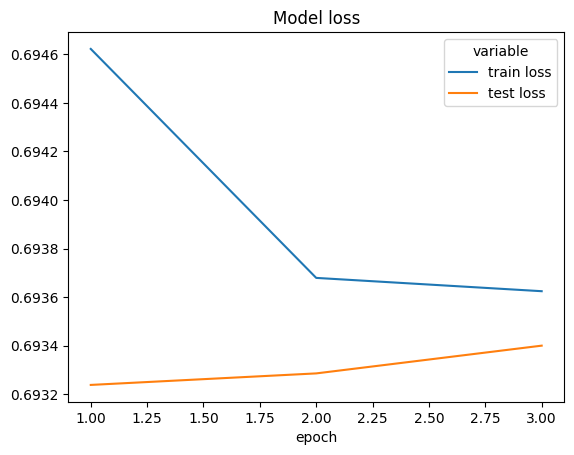

In [ ]:
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss", ylabel=""
)

It makes sense to stop the epochs at that timepoint where the test loss stops dropping, even though the training loss continuous increasing. Otherwise, it leadas to an overfit of the model.


### Evaluation

Finally, we're excited to see how well our model performs. Spoiler alert: Horrible!

In [ ]:
# Load best model from Checkpoint
# model = load_model(PATH_CHECKPOINTS+"lstm-no-embed/Model_300emb_06_0.0757.h5",
#                    compile=False)
# Predict on test data
pred = model.predict(X_test_vec)
pred_class = (pred > 0.5).astype(int)
pred_len = X_test_vec.shape[0]

15/15 [==============================] - 26s 2s/step


In [ ]:
report = metrics.classification_report(Y_test, pred_class[0:pred_len])
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.48      1.00      0.65       220

    accuracy                           0.48       454
   macro avg       0.24      0.50      0.33       454
weighted avg       0.23      0.48      0.32       454



This is pretty bad. There still are a lot of parts and pieces that could be tweaked in this model. This might further increase our scores. 

### Using Pre-trained embeddings

Instead of creating embeddings from scratch as part of a neural network for a specific task, it is also possible to use pre trained embeddings. These have been generated using huge models and data sets and contain large dictionaries. Usually, the vectors of pre trained embeddings capture semantic meaning. For example, two words that are semantic substitues will also have very similar vectors.
Popular choices for embeddings include Word2Vec, GloVe and FastText.  
In order to try to improve our neural network model architecture, we will use FastText embeddings for English.

We can use the Python Library SpaCy, which has word embeddings included.

Let' download and extract the vectors:


In [ ]:
%%time
# Load Fasttext vector embeddings - takes some time 10min

#!pip install spacy
import spacy

print(CURR_PATH)

# Load pre-trained English word vectors from spaCy
!python -m spacy download en_core_web_md
en_model = spacy.load("en_core_web_md")

# No need to load the word vectors separately as spaCy's model already contains them


/content/drive/MyDrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
CPU times: user 5.45 s, sys: 557 ms, total: 6.01 s
Wall time: 25 s


#### Preparing the embeddings

Now, let's see if these properties will help out with our model performance. To get started, we need to assign the correct vector to each of the unique tokens in our comment texts:

In [ ]:
print("Preparing embedding matrix...")

words_not_found = []
# all words from the comments
word_index = tokenizer.word_index  # Assuming you have defined a tokenizer
# max unique words to keep
nb_words = min(MAX_FEATURES, len(word_index))
# define matrix dimensions
EMBED_DIM = 300  # spaCy's vector dimension
embedding_matrix = np.zeros((nb_words, EMBED_DIM))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    try:
        embedding_vector = en_model(word).vector
    except KeyError:
        embedding_vector = None
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

print(f"Null word embeddings: {np.sum(np.sum(embedding_matrix, axis=1) == 0)}")

# Check if words_not_found is not empty before choosing random words
if words_not_found:
    print(
        f"Some of the words not found:\n"
        f"{' '.join([random.choice(words_not_found) for x in range(0, min(10, len(words_not_found)))])}"
    )
else:
    print("All words found in embeddings.")


Preparing embedding matrix...
Null word embeddings: 50
All words found in embeddings.


We can now use this embedding matrix in our neural network. We use it to specify the weights of the embedding layer:

In [ ]:
# Define NN architecture
with strategy.scope():
    model = Sequential()
    model.add(
        Embedding(
            input_dim=MAX_FEATURES,
            output_dim=EMBED_DIM,
            input_length=MAXLEN,
            weights=[embedding_matrix],
            trainable=False,
        )
    )
    model.add(Dropout(0.3))
    model.add(
        Conv1D(FILTERS, KERNEL_SIZE, padding="valid", activation="relu", strides=1)
    )
    model.add(MaxPooling1D(pool_size=POOL_SIZE))
    model.add(LSTM(LSTM_OUTPUT_SIZE))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.RMSprop(),
        metrics=["accuracy"],
    )

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3893, 300)         1500000   
                                                                 
 dropout_2 (Dropout)         (None, 3893, 300)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3886, 64)          153664    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 971, 64)           0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 150)               129000    
                                                                 
 dense_2 (Dense)             (None, 1)                 151       
                                                      

Because we specified the weights and set `trainable = False` for the embedding layer the model won't need to learn new embeddings but just use the ones we provided. Hence, the number of trainable parameters of the model is greatly reduced compared to our first model.  
That was all we needed to change, so let's fit this new model:

In [ ]:
%%time
# Stop training when validation acc starts dropping
# Save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", verbose=1, patience=5),
    ModelCheckpoint(
        PATH_CHECKPOINTS + now + "_Model_FT-Embed_{epoch:02d}_{val_loss:.4f}.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    ),
]

# Fit the model
steps_per_epoch = int(np.floor((len(X_train_vec) / BATCH_SIZE)))
print(
    f"Model Params.\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
)

hist = model.fit(
    X_train_vec,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=(X_test_vec, Y_test),
)

Model Params.
batch_size: 32
Epochs: 15
Step p. Epoch: 42

Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.5037
Epoch 1: val_loss improved from inf to 0.69356, saving model to /models/checkpoints/2024-04-25_0855_Model_FT-Embed_01_0.6936.h5
42/42 [==============================] - 217s 5s/step - loss: 0.6939 - accuracy: 0.5037 - val_loss: 0.6936 - val_accuracy: 0.4846
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4831
Epoch 2: val_loss improved from 0.69356 to 0.69339, saving model to /models/checkpoints/2024-04-25_0855_Model_FT-Embed_02_0.6934.h5
42/42 [==============================] - 220s 5s/step - loss: 0.6932 - accuracy: 0.4831 - val_loss: 0.6934 - val_accuracy: 0.4846
Epoch 3/15
42/42 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5041
Epoch 3: val_loss improved from 0.69339 to 0.69290, saving model to /models/checkpoints/2024-04-25_0855_Model_FT-Embed_03_0.6929.h5
42/42 [

We can now check the prediction results:

In [ ]:
# Predict on test data
pred = model.predict(X_test_vec)
pred_class = (pred > 0.5).astype(int)
pred_len = X_test_vec.shape[0]

15/15 [==============================] - 9s 437ms/step


In [ ]:
report = metrics.classification_report(Y_test, pred_class[0:pred_len])
print(report)

              precision    recall  f1-score   support

           0       0.52      1.00      0.68       234
           1       0.00      0.00      0.00       220

    accuracy                           0.52       454
   macro avg       0.26      0.50      0.34       454
weighted avg       0.27      0.52      0.35       454



The resulting model performs pretty bad. However, because we use embeddings that were trained for a much more general task but not for binary text classification, this is not very surprising. Also, we can easily work around this limitation by allowing our model to further train the embeddings. This is the concept of transfer learning: we use the weights from a model pre trained on a similar, but more general task as starting point. Then, we allow our model to further refine those weights for our specific task. This strategy is extremly powerful, especially in cases where you have only limited data for your specific task. 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3893, 300)         1500000   
                                                                 
 dropout_4 (Dropout)         (None, 3893, 300)         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 3886, 64)          153664    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 971, 64)          0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 971, 64)           33024     
                                                                 
 dropout_5 (Dropout)         (None, 971, 64)           0         
                                                      

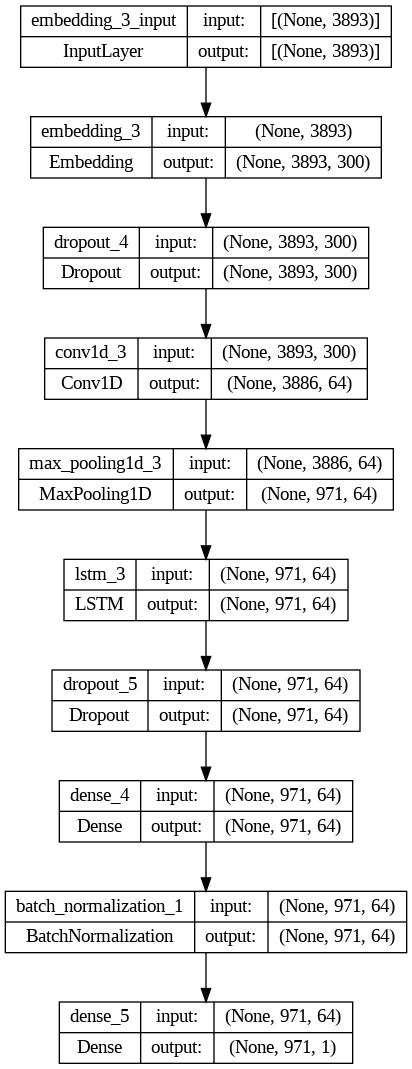

In [ ]:
# Define NN architecture

'''
# Very complex model:
with strategy.scope():
    model = Sequential()
    model.add(
        Embedding(
            input_dim=MAX_FEATURES,
            output_dim=EMBED_DIM,
            input_length=MAXLEN,
            weights=[embedding_matrix],
            trainable=True,
        )
    )
    model.add(Dropout(0.5))
    model.add(
        Conv1D(FILTERS, KERNEL_SIZE, padding="valid", activation="relu", strides=1)
    )
    model.add(MaxPooling1D(pool_size=POOL_SIZE))
    # We add bidirectional layer, so that it can learn from past and future inputs
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Dropout(0.7))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.7))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.7))

    # Attention layer
    attn_layer = Attention(use_scale=True)
    attn_out = attn_layer([model.layers[-1].output, model.layers[-1].output])

    # Concatenate attention output and LSTM output
    concat_input = Concatenate(axis=-1)([model.layers[-1].output, attn_out])

    model.add(Dense(128, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        #optimizer=tf.keras.optimizers.RMSprop(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        metrics=["accuracy"],
    )
    model.summary()
'''

# Less complex model:
with strategy.scope():
    model = Sequential()
    model.add(
        Embedding(
            input_dim=MAX_FEATURES,
            output_dim=EMBED_DIM,
            input_length=MAXLEN,
            weights=[embedding_matrix],
            trainable=True,
        )
    )
    model.add(Dropout(0.1))
    model.add(
        Conv1D(FILTERS, KERNEL_SIZE, padding="valid", activation="relu", strides=1)
    )
    model.add(MaxPooling1D(pool_size=POOL_SIZE))
    # We add bidirectional layer, so that it can learn from past and future inputs
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))


    # Attention layer
    attn_layer = Attention(use_scale=True)
    attn_out = attn_layer([model.layers[-1].output, model.layers[-1].output])

    # Concatenate attention output and LSTM output
    concat_input = Concatenate(axis=-1)([model.layers[-1].output, attn_out])

    model.add(Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        #optimizer=tf.keras.optimizers.RMSprop(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"],
    )
    model.summary()

# Visualize the model architecture
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)



In [ ]:
%%time
# Stop training when validation acc starts dropping
# Save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", verbose=1, patience=2),
    ModelCheckpoint(
        PATH_CHECKPOINTS
        + now
        + "_Model_FT-Embed-trainable_{epoch:02d}_{val_loss:.4f}.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    ),
]

# Fit the model
steps_per_epoch = int(np.floor((len(X_train_vec) / BATCH_SIZE)))
print(
    f"Model Params.\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
)

hist = model.fit(
    X_train_vec,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=(X_test_vec, Y_test),
)

Model Params.
batch_size: 256
Epochs: 15
Step p. Epoch: 5

Epoch 1/15
5/5 [==============================] - ETA: 0s - loss: 1.3458 - accuracy: 0.4911
Epoch 1: val_loss improved from inf to 1.28799, saving model to /models/checkpoints/2024-04-09_1553_Model_FT-Embed-trainable_01_1.2880.h5
5/5 [==============================] - 45s 5s/step - loss: 1.3458 - accuracy: 0.4911 - val_loss: 1.2880 - val_accuracy: 0.5156
Epoch 2/15
5/5 [==============================] - ETA: 0s - loss: 1.2842 - accuracy: 0.4946
Epoch 2: val_loss improved from 1.28799 to 1.24934, saving model to /models/checkpoints/2024-04-09_1553_Model_FT-Embed-trainable_02_1.2493.h5
5/5 [==============================] - 12s 530ms/step - loss: 1.2842 - accuracy: 0.4946 - val_loss: 1.2493 - val_accuracy: 0.5154
Epoch 3/15
5/5 [==============================] - ETA: 0s - loss: 1.2421 - accuracy: 0.4999
Epoch 3: val_loss improved from 1.24934 to 1.21226, saving model to /models/checkpoints/2024-04-09_1553_Model_FT-Embed-trainable

After allowing our embedding layer to further refine the pre trained FastText embeddings, here is the result:

In [ ]:
# Predict on test data
pred = model.predict(X_test_vec)
pred_class = (pred > 0.5).astype(int)
pred_len = X_test_vec.shape[0]
# Show prediction metrics
report = metrics.classification_report(Y_test, pred_class[0:pred_len])
print(report)

15/15 [==============================] - 9s 457ms/step


ValueError: Classification metrics can't handle a mix of binary and unknown targets

On the first look, this model performs horribly bad. So using a LTSM neural network with fine tuned FastText embeddings is our worst performant classifier so far! 